Задание №1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy
from scipy.stats import shapiro, boxcox
from statsmodels.stats.api import (het_breuschpagan,
                                   het_goldfeldquandt,
                                   het_white, jarque_bera,
                                   omni_normtest, normal_ad)
from statsmodels.stats.diagnostic import kstest_normal, normal_ad
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.formula.api import ols
from statsmodels.tools.tools import add_constant
from scipy.stats import shapiro, kstest, normaltest
from statsmodels.stats.diagnostic import kstest_normal, normal_ad

import warnings
warnings.filterwarnings("ignore")

In [2]:
def is_normal(dataset, test, p_level=0.05):
    stat, pval = test
    return 'dataset {}, test {}: Normal'.format(dataset, test) if pval < p_level else 'Not Normal'

def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
    
def tsplot(y, lags=None, figsize=(12, 7), style='bmh', d_name=None):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        p_value = sm.tsa.stattools.adfuller(y)[1]
        if p_value >0.05:
            l_text = 'Ряд для {} не является стационарным'.format(d_name)
        else:
            l_text = 'Ряд для {} является стационарным'.format(d_name) 

        y.plot(ax=ts_ax, label=l_text)
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        ts_ax.legend()

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()


def diff_series(dataset):
    dataset['log_price_diff'] = dataset.log_price_diff.diff().dropna()
    test = sm.tsa.adfuller(dataset.log_price_diff.dropna())
    return test

GAZP общая информация: 
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1446 entries, 2017-01-03 to 2022-10-19
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   1446 non-null   float64
dtypes: float64(1)
memory usage: 22.6 KB
None
             Price
count  1446.000000
mean    199.252552
std      64.066682
min     115.350000
25%     145.720000
50%     185.395000
75%     234.587500
max     389.820000

EOG общая информация:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1459 entries, 2017-01-03 to 2022-10-18
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   1459 non-null   float64
dtypes: float64(1)
memory usage: 22.8 KB
None
             Price
count  1459.000000
mean     87.177738
std      25.283805
min      29.760000
25%      70.690000
50%      91.020000
75%     105.395000
max     142.190000
Проверяем распределение на нормальность:
dataset 

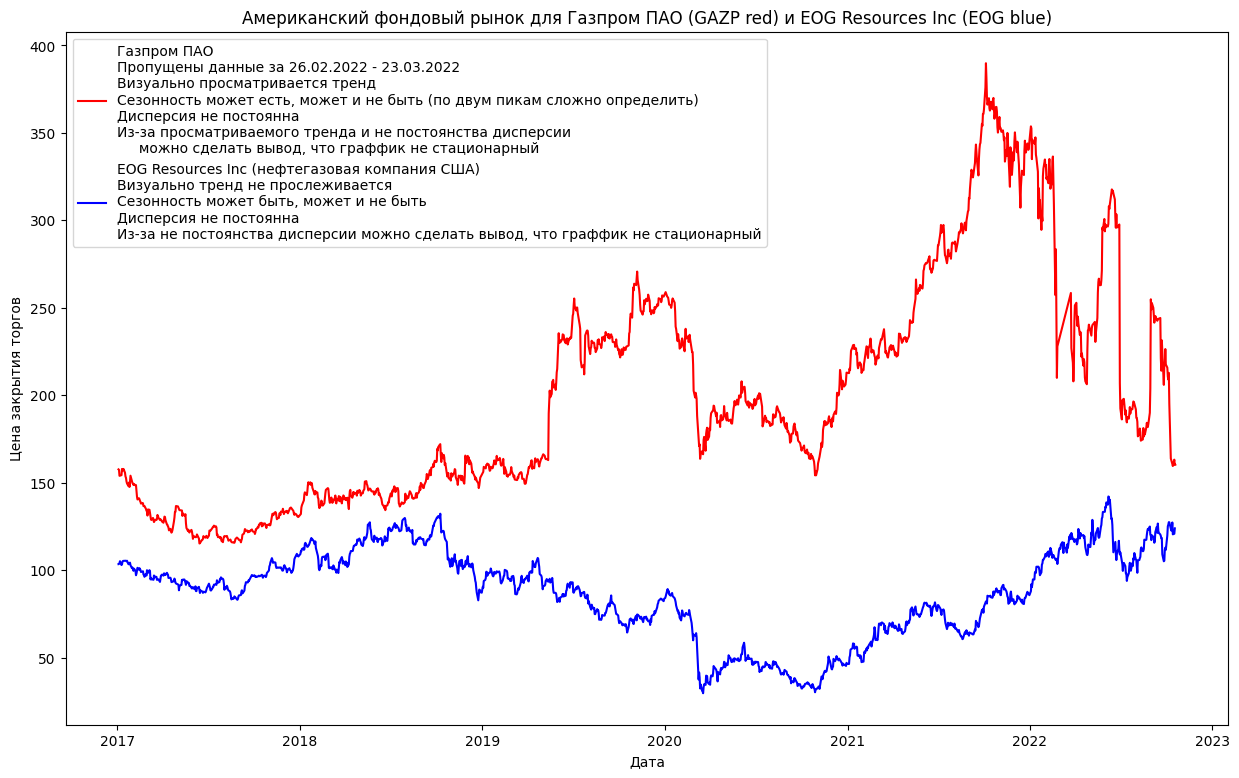

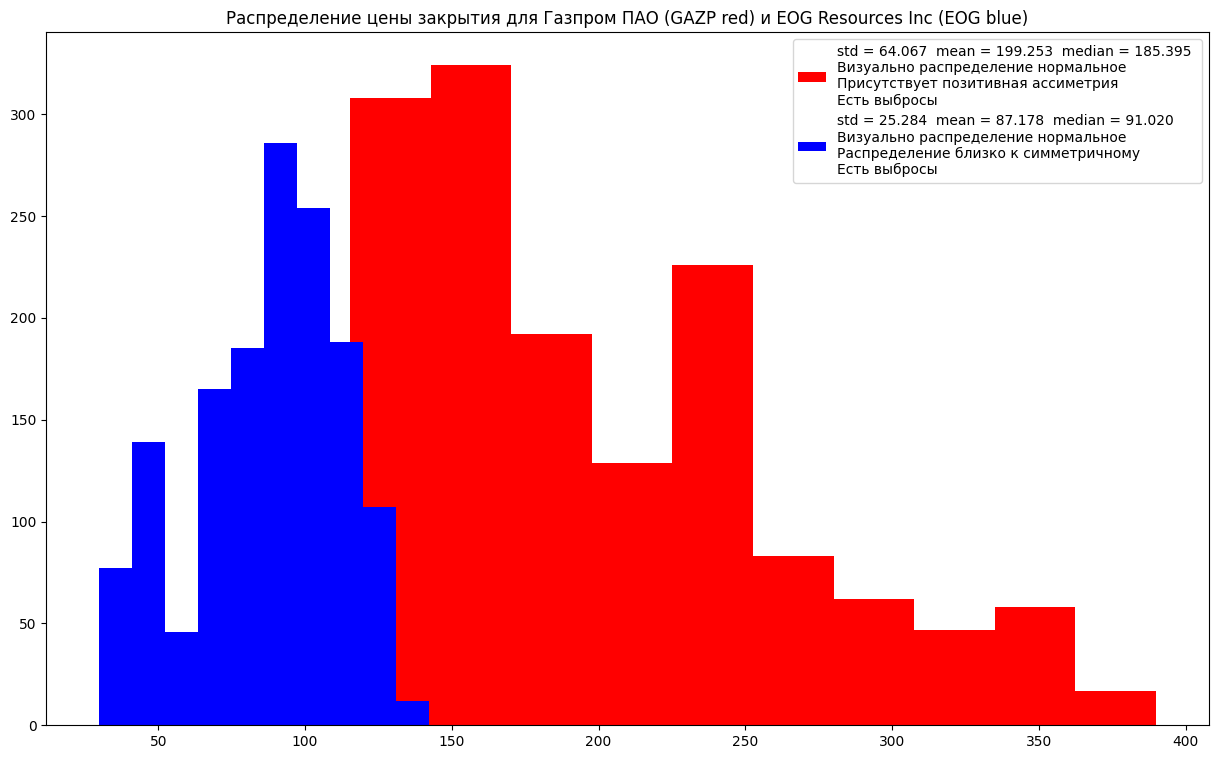

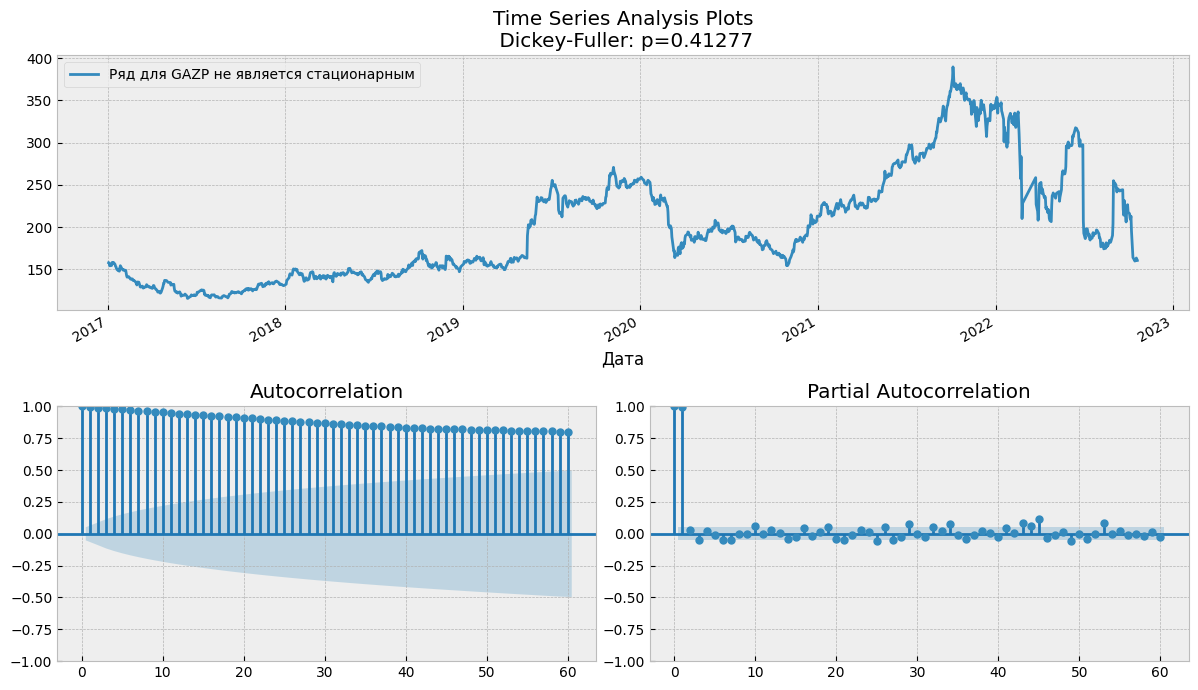

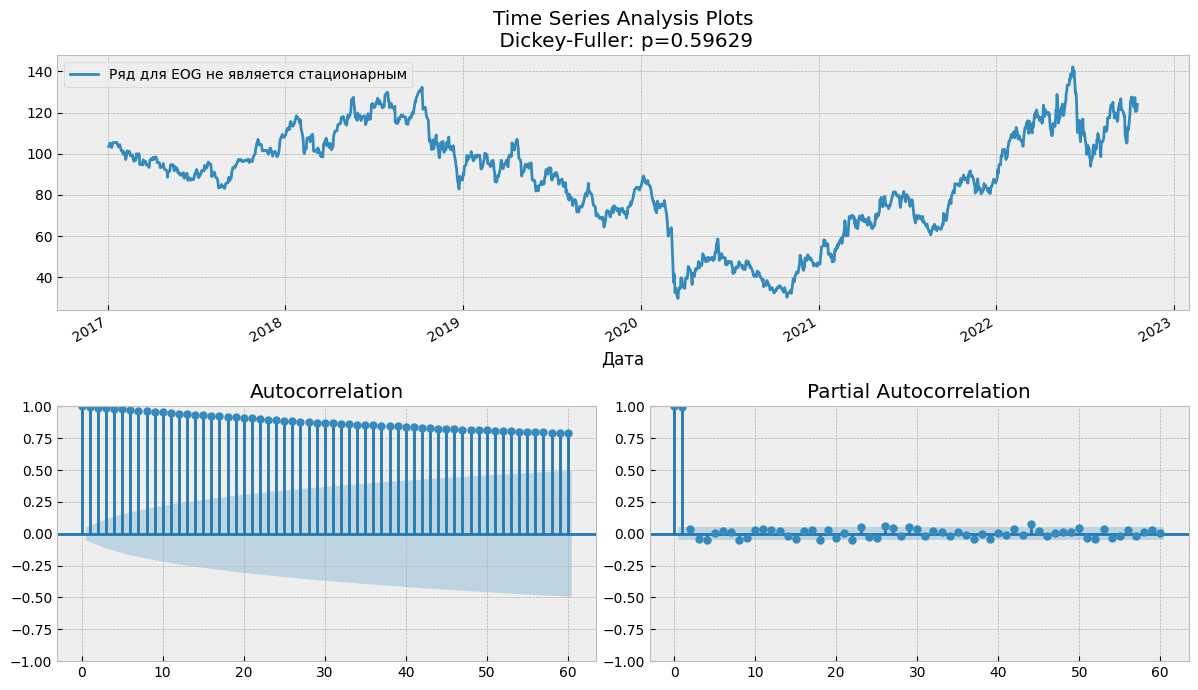

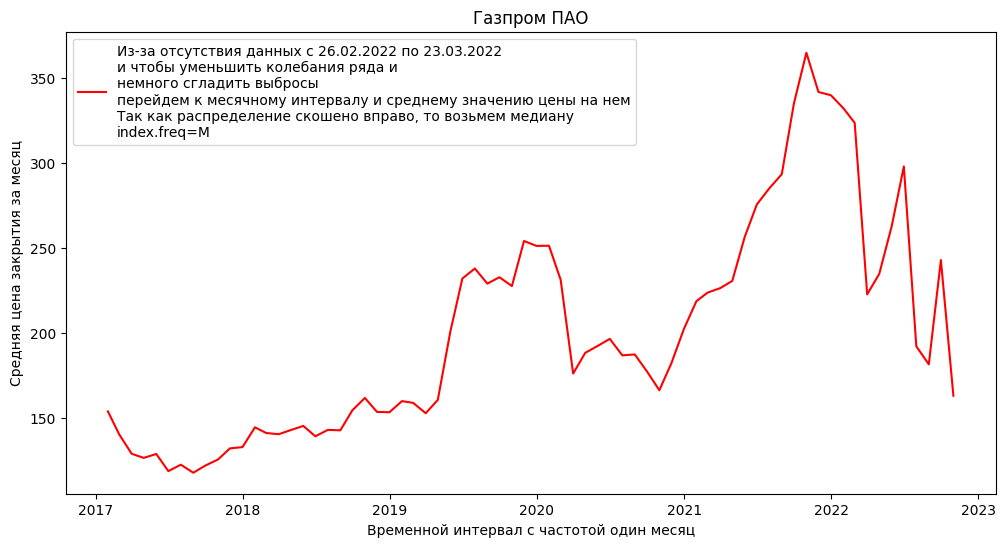

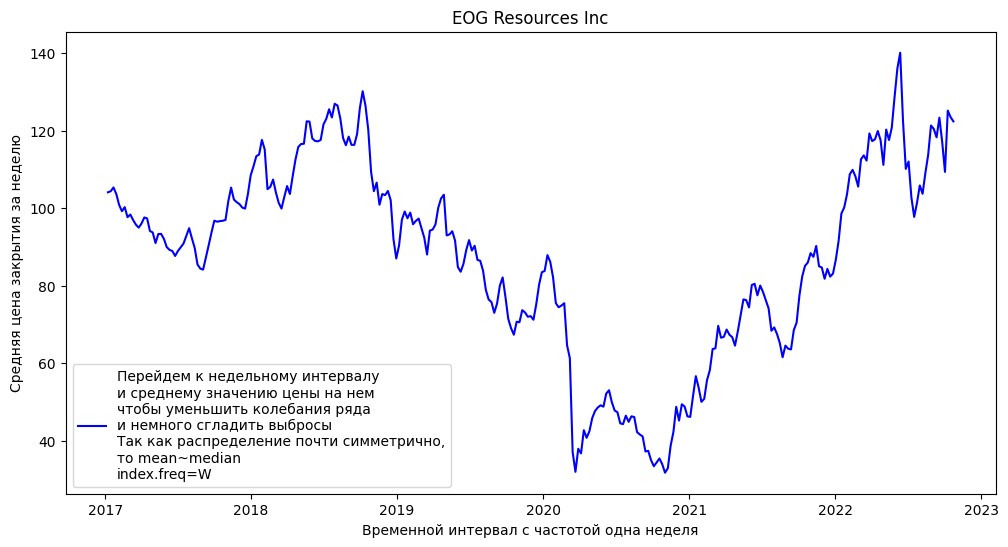

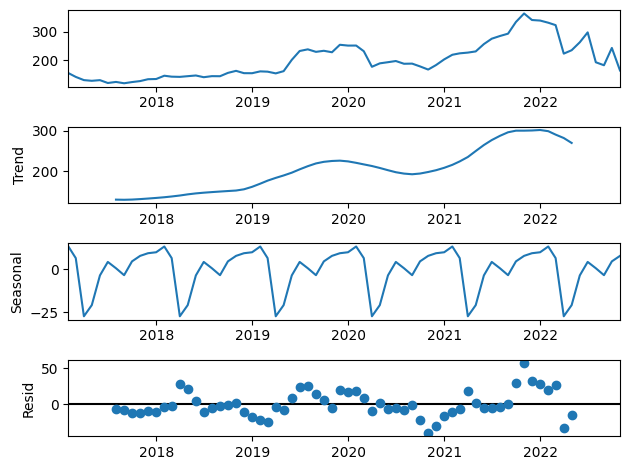

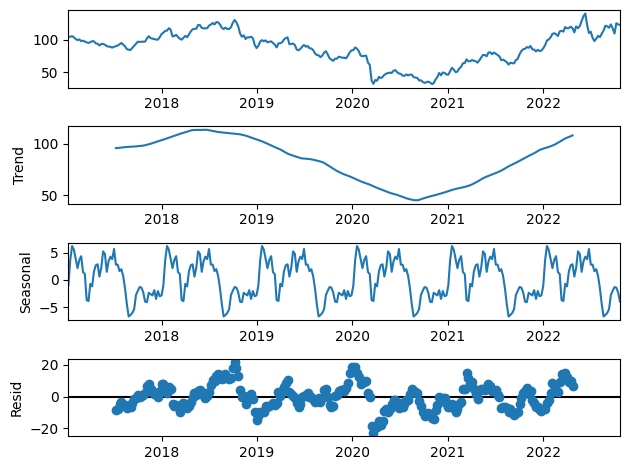

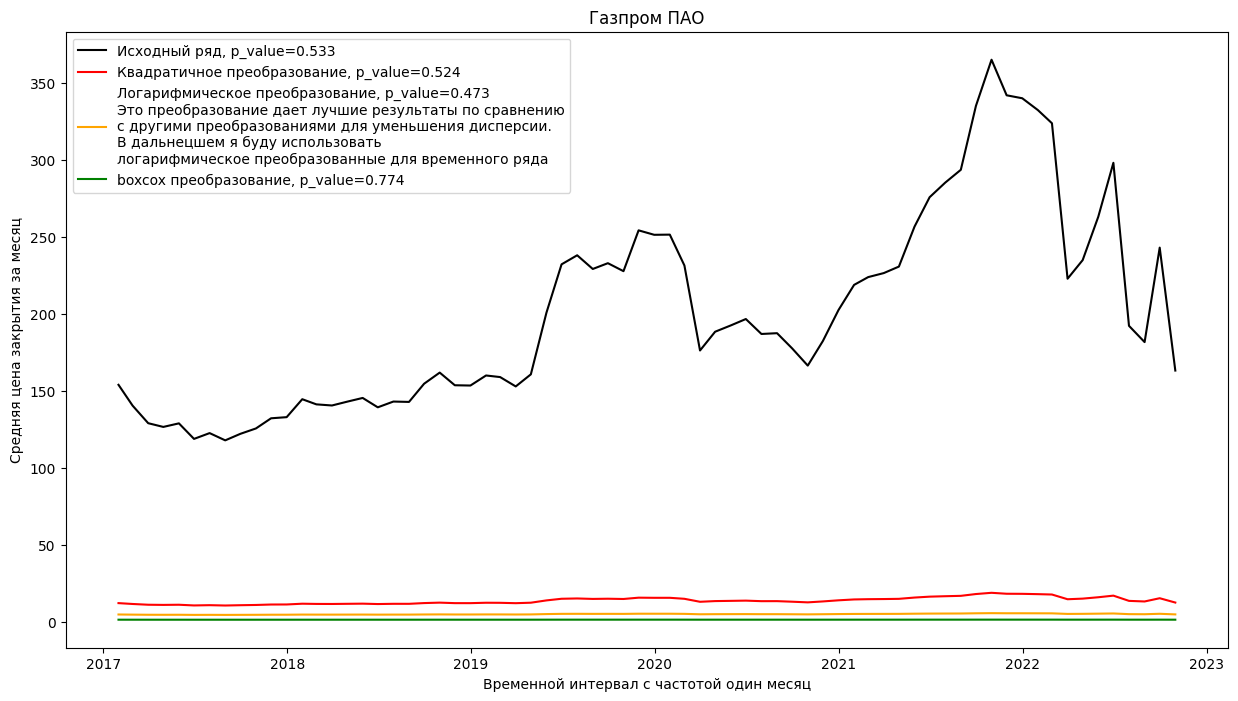

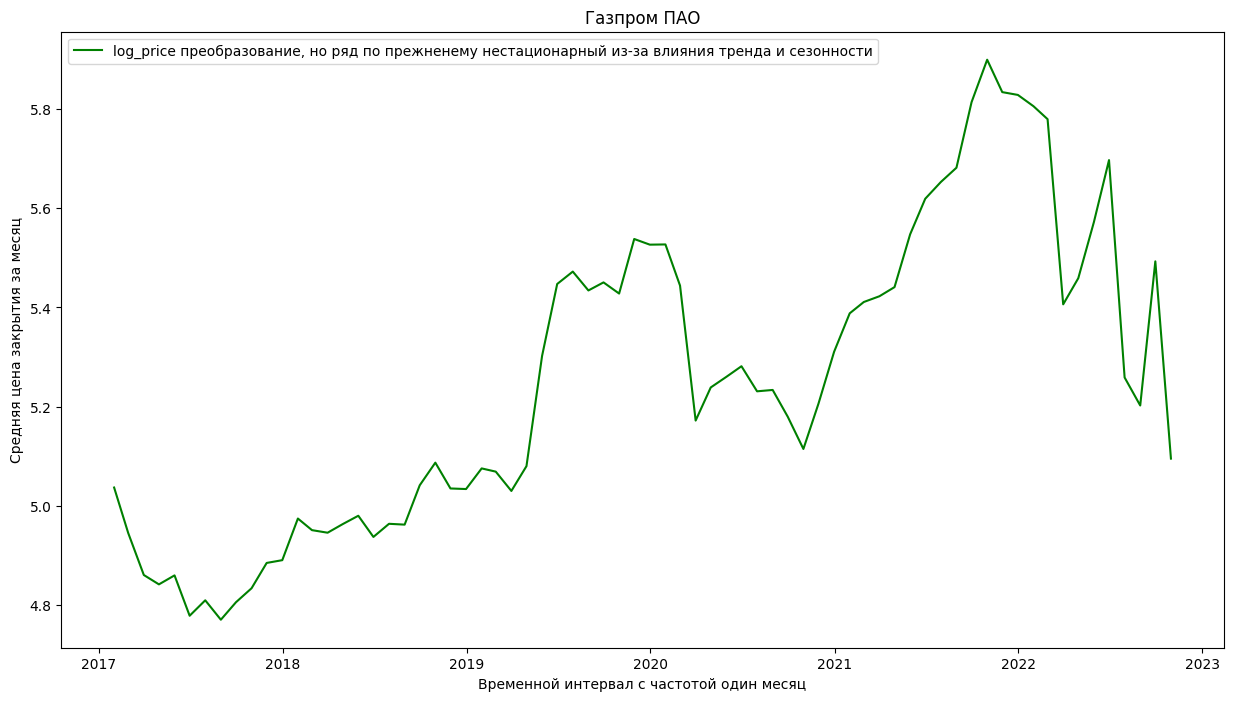

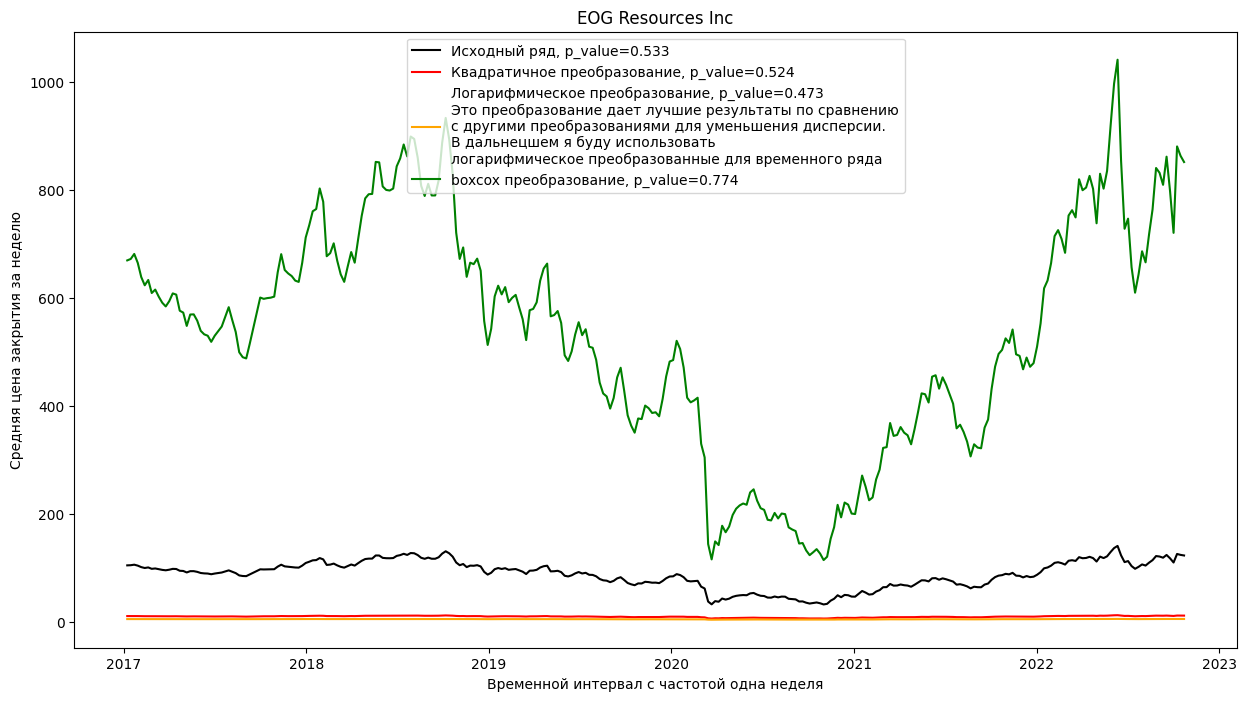

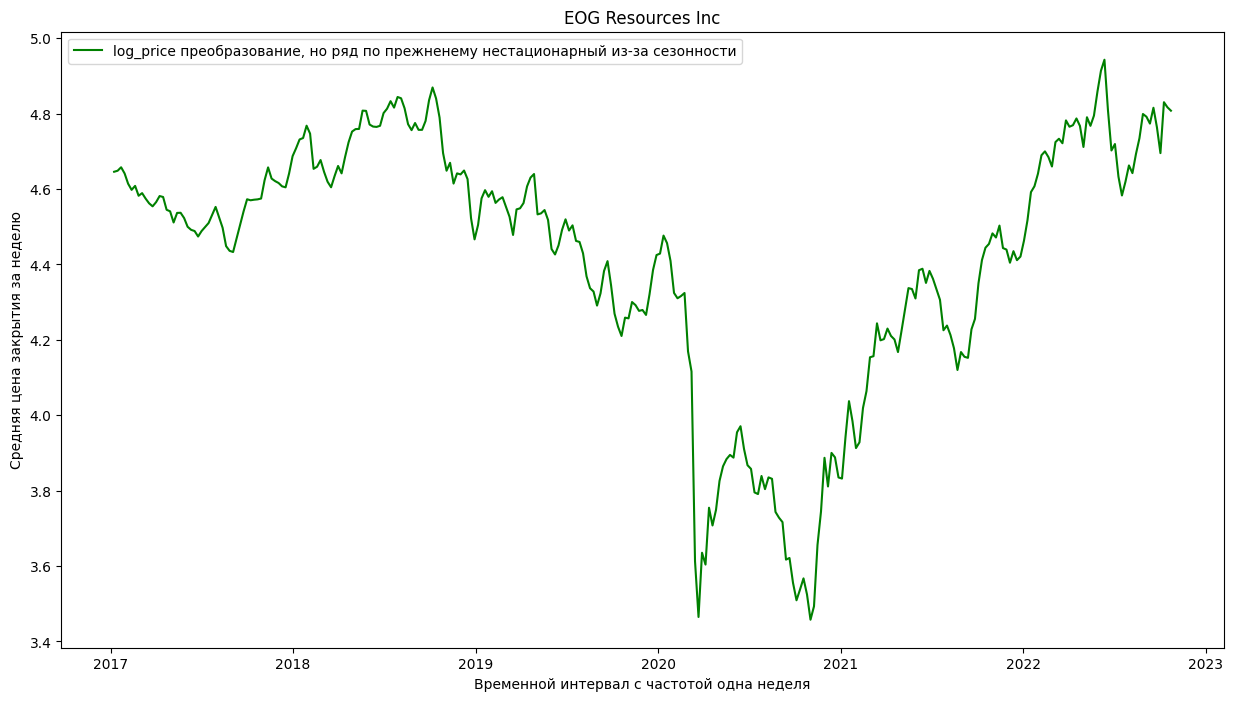

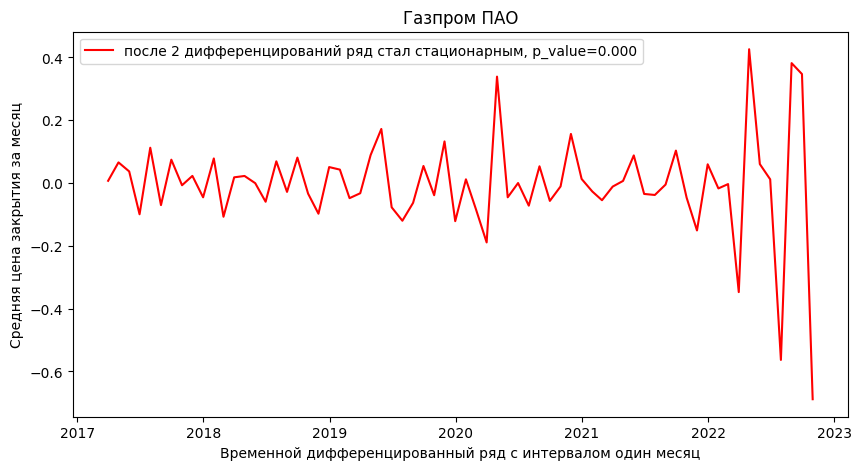

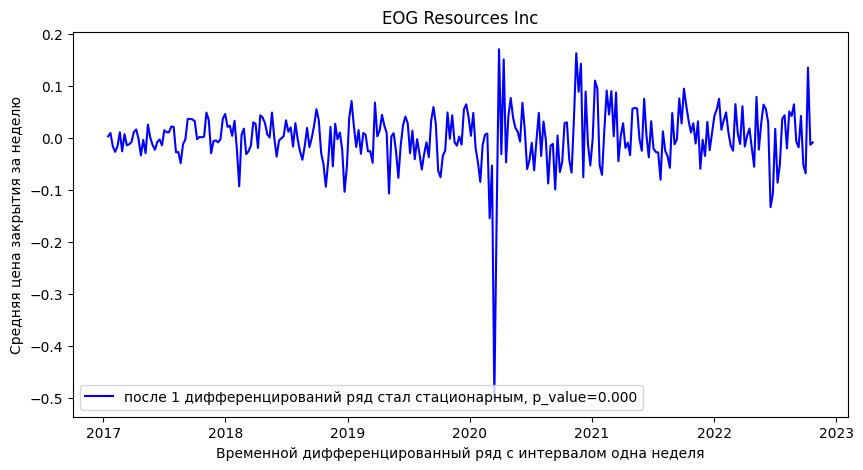

In [3]:
GAZP = pd.read_csv('/home/mikhail/it-academy/модуль 7/Прошлые данные - GAZP.csv',sep=';')#, index_col=['Дата'], parse_dates=['Дата'])
EOG = pd.read_csv('/home/mikhail/it-academy/модуль 7/Прошлые данные - EOG.csv', sep=';')

GAZP = GAZP.rename(columns = {'Цена':'Price'})
GAZP['Дата'] = pd.to_datetime(GAZP['Дата'],format='%d.%m.%Y')
GAZP = GAZP.pivot_table(index="Дата")

EOG = EOG.rename(columns = {'Цена':'Price'})
EOG['Дата'] = pd.to_datetime(EOG['Дата'],format='%d.%m.%Y')
EOG = EOG.pivot_table(index="Дата")

print('GAZP общая информация: ')
print(GAZP.info())
print(GAZP.describe())
print()
print('EOG общая информация:')
print(EOG.info())
print(EOG.describe())

fig1, ax1 = plt.subplots(figsize=(15,9))
ax1.plot(GAZP.index, GAZP.Price, c='red', label='Газпром ПАО\nПропущены данные за 26.02.2022 - 23.03.2022\nВизуально просматривается тренд\nСезонность может есть, может и не быть (по двум пикам сложно определить)\nДисперсия не постоянна\nИз-за просматриваемого тренда и не постоянства дисперсии\n     можно сделать вывод, что граффик не стационарный')
ax1.plot(EOG.index, EOG.Price, c='blue', label='EOG Resources Inc (нефтегазовая компания США)\nВизуально тренд не прослеживается\nСезонность может быть, может и не быть\nДисперсия не постоянна\nИз-за не постоянства дисперсии можно сделать вывод, что граффик не стационарный')
ax1.set_xlabel('Дата')
ax1.set_ylabel('Цена закрытия торгов')
ax1.set_title('Американский фондовый рынок для Газпром ПАО (GAZP red) и EOG Resources Inc (EOG blue)');
plt.legend()

fig2, ax2 = plt.subplots(figsize=(15,9))
ax2.hist(GAZP.Price, color='red',label='std = {:.3f}  mean = {:.3f}  median = {:.3f} \nВизуально распределение нормальное\nПрисутствует позитивная ассиметрия\nЕсть выбросы'.format(GAZP.Price.std(),GAZP.Price.mean(),GAZP.Price.median()))
ax2.hist(EOG.Price, color='blue',label='std = {:.3f}  mean = {:.3f}  median = {:.3f} \nВизуально распределение нормальное\nРаспределение близко к симметричному\nЕсть выбросы'.format(EOG.Price.std(),EOG.Price.mean(),EOG.Price.median()))
ax2.set_title('Распределение цены закрытия для Газпром ПАО (GAZP red) и EOG Resources Inc (EOG blue)')
plt.legend()

print('Проверяем распределение на нормальность:')


df = [('GAZP',GAZP), ('EOG',EOG)]

for df_name, df_data in df:
    normal_args = (np.mean(df_data.Price),np.std(df_data.Price))

    print(is_normal(df_name,shapiro(df_data.Price)))
    print(is_normal(df_name, normaltest(df_data.Price)))
    print(is_normal(df_name, normal_ad(df_data.Price)))
    print(is_normal(df_name, kstest_normal(df_data.Price)))
    print(is_normal(df_name, kstest(df_data.Price,
                    cdf='norm',
                    args=normal_args)))
print('Визуальный анализ и тесты из библиотеки statsmodels говорят, что оба распределения нормальные')


tsplot(GAZP.Price, lags=60, d_name='GAZP')
tsplot(EOG.Price, lags=60, d_name='EOG')


GAZP = GAZP.resample(rule='M').median() 
fig3, ax3 = plt.subplots(figsize=(12,6))
ax3.plot(GAZP.Price,color='red',label='Из-за отсутствия данных с 26.02.2022 по 23.03.2022\nи чтобы уменьшить колебания ряда и\nнемного сгладить выбросы\nперейдем к месячному интервалу и среднему значению цены на нем\nТак как распределение скошено вправо, то возьмем медиану\nindex.freq=M')
ax3.set_xlabel('Временной интервал с частотой один месяц')
ax3.set_ylabel('Средняя цена закрытия за месяц')
ax3.set_title('Газпром ПАО')
plt.legend()

EOG = EOG.resample(rule='W').mean() 
fig4, ax4 = plt.subplots(figsize=(12,6))
ax4.plot(EOG.Price,color='blue',label='Перейдем к недельному интервалу\nи среднему значению цены на нем\nчтобы уменьшить колебания ряда\nи немного сгладить выбросы\nТак как распределение почти симметрично,\nто mean~median\nindex.freq=W')
ax4.set_xlabel('Временной интервал с частотой одна неделя')
ax4.set_ylabel('Средняя цена закрытия за неделю')
ax4.set_title('EOG Resources Inc')
plt.legend()


seasonal_decompose(GAZP, model='additive').plot()
print('разложение ряда на компоненты говорит, что тренд и сезонность присутствует для GAZP')
seasonal_decompose(EOG, model='additive').plot() #multiplicative
print('разложение ряда на компоненты говорит, что сезонность присутствует для EOG')


GAZP['Price_sqrt'] = np.sqrt(GAZP['Price'])
GAZP['log_price'] = np.log(GAZP['Price'])
data, lambda_power = scipy.stats.boxcox(GAZP['Price'])
GAZP['boxcox_price'] = data

EOG['Price_sqrt'] = np.sqrt(EOG['Price'])
EOG['log_price'] = np.log(EOG['Price'])
data, lambda_power = scipy.stats.boxcox(EOG['Price'])
EOG['boxcox_price'] = data

#GAZP['exponential_smoothing_price'] = exponential_smoothing(GAZP.Price, 0.5)



fig5, ax5 = plt.subplots(figsize=(15,8))
p_value = sm.tsa.stattools.adfuller(EOG.Price)[1]
ax5.plot(GAZP.Price,color='black',label='Исходный ряд, p_value={:.3f}'.format(p_value))
p_value = sm.tsa.stattools.adfuller(EOG.Price_sqrt)[1]
ax5.plot(GAZP.Price_sqrt,color='red', label='Квадратичное преобразование, p_value={:.3f}'.format(p_value))
p_value = sm.tsa.stattools.adfuller(EOG.log_price)[1]
ax5.plot(GAZP.log_price,color='orange', label='Логарифмическое преобразование, p_value={:.3f}\nЭто преобразование дает лучшие результаты по сравнению\nс другими преобразованиями для уменьшения дисперсии.\nВ дальнецшем я буду использовать\nлогарифмическое преобразованные для временного ряда'.format(p_value))
p_value = sm.tsa.stattools.adfuller(EOG.boxcox_price)[1]
ax5.plot(GAZP.boxcox_price,color='green', label='boxcox преобразование, p_value={:.3f}'.format(p_value))
#ax5.plot(GAZP.exponential_smoothing_price,color='red',label='Исходный ряд')
ax5.set_xlabel('Временной интервал с частотой один месяц')
ax5.set_ylabel('Средняя цена закрытия за месяц')
ax5.set_title('Газпром ПАО')
plt.legend()

fig6, ax6 = plt.subplots(figsize=(15,8))
ax6.plot(GAZP.log_price,color='green',label='log_price преобразование, но ряд по прежненему нестационарный из-за влияния тренда и сезонности')
ax6.set_xlabel('Временной интервал с частотой один месяц')
ax6.set_ylabel('Средняя цена закрытия за месяц')
ax6.set_title('Газпром ПАО')
plt.legend()


fig7, ax7 = plt.subplots(figsize=(15,8))
p_value = sm.tsa.stattools.adfuller(EOG.Price)[1]
ax7.plot(EOG.Price,color='black',label='Исходный ряд, p_value={:.3f}'.format(p_value))
p_value = sm.tsa.stattools.adfuller(EOG.Price_sqrt)[1]
ax7.plot(EOG.Price_sqrt,color='red', label='Квадратичное преобразование, p_value={:.3f}'.format(p_value))
p_value = sm.tsa.stattools.adfuller(EOG.log_price)[1]
ax7.plot(EOG.log_price,color='orange', label='Логарифмическое преобразование, p_value={:.3f}\nЭто преобразование дает лучшие результаты по сравнению\nс другими преобразованиями для уменьшения дисперсии.\nВ дальнецшем я буду использовать\nлогарифмическое преобразованные для временного ряда'.format(p_value))
p_value = sm.tsa.stattools.adfuller(EOG.boxcox_price)[1]
ax7.plot(EOG.boxcox_price,color='green', label='boxcox преобразование, p_value={:.3f}'.format(p_value))
ax7.set_xlabel('Временной интервал с частотой одна неделя')
ax7.set_ylabel('Средняя цена закрытия за неделю')
ax7.set_title('EOG Resources Inc')
plt.legend()

fig8, ax8 = plt.subplots(figsize=(15,8))
ax8.plot(EOG.log_price,color='green',label='log_price преобразование, но ряд по прежненему нестационарный из-за сезонности')
ax8.set_xlabel('Временной интервал с частотой одна неделя')
ax8.set_ylabel('Средняя цена закрытия за неделю')
ax8.set_title('EOG Resources Inc')
plt.legend()


print('Дифференцирование ряда для преобразования его в стационарный ряд: ')
GAZP['log_price_diff'] = GAZP.log_price
EOG['log_price_diff'] = EOG.log_price


stat_series = False
n_diff = 0
for n in range(10):
    n_diff += 1
    test = diff_series(GAZP)
    if test[0] < test[4]['5%']: 
        stat_series = True
        break;

print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if stat_series == True:
    fig9, ax9 = plt.subplots(figsize=(10,5))
    ax9.plot(GAZP.log_price_diff,color='red',label='после {} дифференцирований ряд стал стационарным, p_value={:.3f}'.format(n_diff, test[1]))
    ax9.set_xlabel('Временной дифференцированный ряд с интервалом один месяц')
    ax9.set_ylabel('Средняя цена закрытия за месяц')
    ax9.set_title('Газпром ПАО')
    plt.legend()
else:
    fig9, ax9 = plt.subplots(figsize=(10,5))
    ax9.plot(GAZP.log_price_diff,color='red',label='после {} дифференцирований ряд по прежнему не стационарный, p_value={:.3f}'.format(n, test[1]))
    ax9.set_xlabel('Временной дифференцированный ряд с интервалом один месяц')
    ax9.set_ylabel('Средняя цена закрытия за месяц')
    ax9.set_title('Газпром ПАО')
    plt.legend()    


stat_series = False
n_diff = 0
for n in range(10):
    n_diff += 1
    test = diff_series(EOG)
    if test[0] < test[4]['5%']: 
        stat_series = True
        break;

print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if stat_series == True:
    fig10, ax10 = plt.subplots(figsize=(10,5))
    ax10.plot(EOG.log_price_diff,color='blue',label='после {} дифференцирований ряд стал стационарным, p_value={:.3f}'.format(n_diff, test[1]))
    ax10.set_xlabel('Временной дифференцированный ряд с интервалом одна неделя')
    ax10.set_ylabel('Средняя цена закрытия за неделю')
    ax10.set_title('EOG Resources Inc')
    plt.legend()
else:
    fig10, ax10 = plt.subplots(figsize=(10,5))
    ax10.plot(EOG.log_price_diff,color='blue',label='после {} дифференцирований ряд по прежнему не стационарный, p_value={:.3f}'.format(n, test[1]))
    ax10.set_xlabel('Временной дифференцированный ряд с интервалом одна неделя')
    ax10.set_ylabel('Средняя цена закрытия за неделю')
    ax10.set_title('EOG Resources Inc')
    plt.legend()    
    
#fig7, ax7 = plt.subplots(figsize=(12,6))
#ax7.plot(GAZP.exponential_smoothing_price,color='green',label='boxcox преобразование')
#ax7.set_xlabel('Временной интервал с частотой один месяц')
#ax7.set_ylabel('Средняя цена закрытия за месяц')
#ax7.set_title('Газпром ПАО')
#plt.legend()


Вывод

Датасет GAZP:
Временной ряд фондовой биржи США с временным интервалом 1 день. Имеется пропущенные данные потому что в выходные и праздничные дни биржа не работает, также имеется пропущенные данные за большой интервал времени с 26.02.2022 по 23.03.2022. Чтобы уменьшить колебания ряда и немного сгладить выбросы, а также избавиться от пропущенных значений перешел к месячнному интервалу ряда и усредненному значению на нем. Усреднял по медианному значению, так как распределение ряда является нормальным (подтверждено разными статистическими тестами) и скошено вправо. Ряд имеет тренд, сезонность и большой разброс дисперсии и следовательно он не является стационарным, также это было подтверждено статистическим тестом Дикки-Фуллера. Для уменьшения разброса дисперсии использовал логарифмическое преобразование потому что p-статистика (Дикки-Фуллер) показала наилучшие результаты по сравнению с квадратичным преобразованием, преобразованием Бокса-Кокса. Чтобы избавиться от тренда, сезонности и уменьшить дисперсию использовал дифференцирование. Тест Дикки-Фуллера показал, что для данного ряда достаточно двух дифференцирований.

Датасет EOG:
Временной ряд фондовой биржи США с временным интервалом 1 день. Имеется пропущенные данные потому что в выходные и праздничные дни биржа не работает. Чтобы уменьшить колебания ряда и немного сгладить выбросы, а также избавиться от пропущенных значений перешел к недельному интервалу ряда и усредненному значению на нем. Усреднял по среднему арифметическому значению, так как распределение ряда является нормальным (подтверждено разными статистическими тестами) и близко к симметричному. Ряд имеет сезонность и большой разброс дисперсии и следовательно он не является стационарным, также это было подтверждено статистическим тестом Дикки-Фуллера. Для уменьшения разброса дисперсии использовал логарифмическое преобразование потому что p-статистика (Дикки-Фуллер) показала наилучшие результаты по сравнению с квадратичным преобразованием, преобразованием Бокса-Кокса. Чтобы избавиться от сезонности и уменьшить дисперсию использовал дифференцирование. Тест Дикки-Фуллера показал, что для данного ряда достаточно одного дифференцирования.

Задание №2

  0%|          | 0/36 [00:00<?, ?it/s]

                                      SARIMAX Results                                      
Dep. Variable:                           log_price   No. Observations:                   70
Model:             SARIMAX(2, 1, 3)x(1, 1, [], 12)   Log Likelihood                  41.844
Date:                             Tue, 25 Oct 2022   AIC                            -69.688
Time:                                     01:14:36   BIC                            -55.386
Sample:                                 01-31-2017   HQIC                           -64.130
                                      - 10-31-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1141      0.122      0.935      0.350      -0.125       0.353
ar.L2         -0.8604      

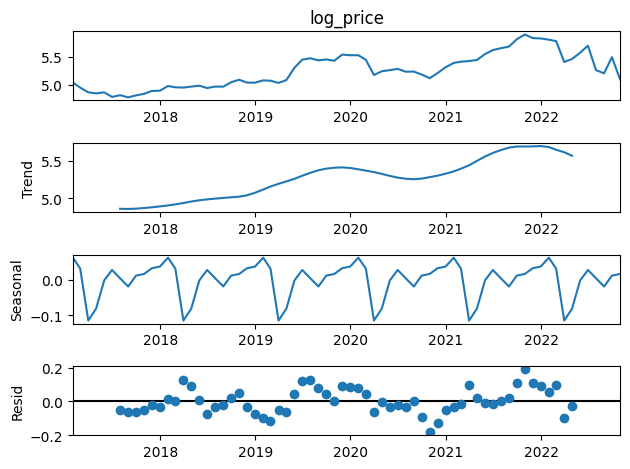

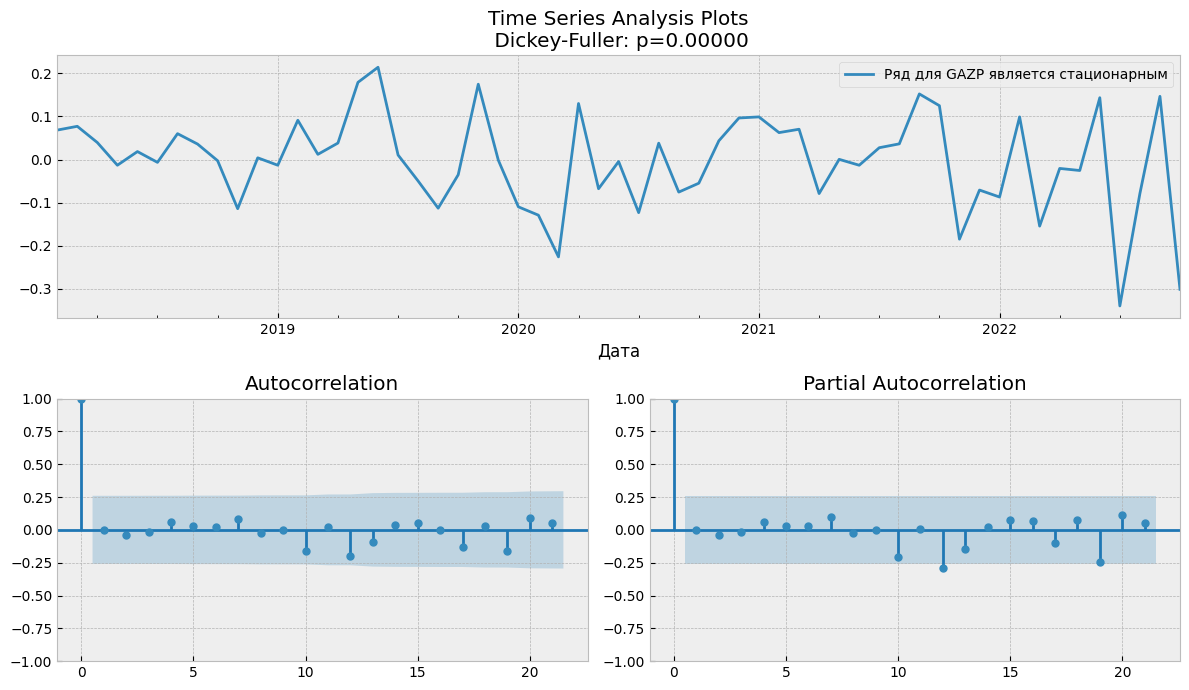

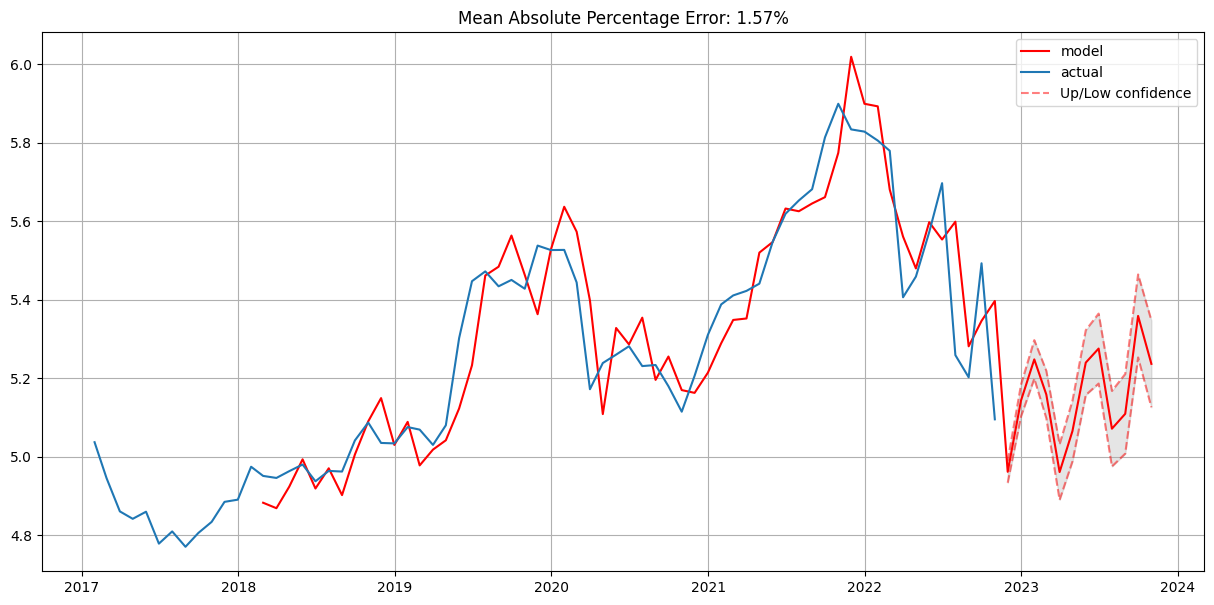

In [6]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from tqdm import tqdm_notebook
from itertools import product



def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC

        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order
        s - length of season
    """

    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(GAZP.Price, order=(param[0], d, param[1]),
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return result_table


def plotSARIMA(series, model, n_steps, s=24, d=1, plot_intervals=True, alpha=0.2):
    """
        Plots model vs predicted values

        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future

    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN

    # forecasting on n_steps forward
    forecast = best_model.get_forecast(steps=n_steps)
    model_predictions = data.arima_model.append(forecast.predicted_mean)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])


    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))

    plt.plot(model_predictions, color='r', label="model")
    plt.plot(data.actual, label="actual")

    if plot_intervals:
        intervals = forecast.conf_int(alpha=alpha)
        intervals.columns=['lower', 'upper']
        plt.plot(intervals['lower'], "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(intervals['upper'], "r--", alpha=0.5)
        plt.fill_between(x=intervals.index, y1=intervals['upper'],
                         y2=intervals['lower'], alpha=0.2, color = "grey")


    plt.legend()
    plt.grid(True);


#GAZP['exponential_smoothing_price'] = exponential_smoothing(GAZP.Price, 0.5)
#GAZP['log_price_exp'] = np.log(GAZP['exponential_smoothing_price'])

seasonal_decompose(GAZP.log_price, model='additive').plot()


# setting initial values and some bounds for them
ps = range(2, 5)
d=1
qs = range(2, 5)
Ps = range(0, 2)
D=1
Qs = range(0, 2)
s = 12 # season length is still 12

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
#print(len(parameters_list))

result_table = optimizeSARIMA(parameters_list, d, D, s)

p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(GAZP.log_price, order=(p, d, q),
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

tsplot(best_model.resid[12+1:], lags=21, d_name='GAZP')

GAZPPrice = GAZP.drop(['Price_sqrt','Price','boxcox_price','log_price_diff'],axis=1)

plotSARIMA(GAZPPrice, best_model, 12, s=12, d=1, alpha=0.8)

Вывод

Я выбрал метод сезонного авторегрессионного интегрированного скользящего среднего (SARIMA) для прогнозирования временного ряда GAZP. Эта модель наиболее всего подходит для данной задачи потому что ряд имеет помимо тренда, еще и сезонность, с которой модель ARIMA плохо справляется. Ряд имеет небольшой разброс дисперсии, но с помощью логарифмической трансформации данных влияние дисперсии удалось уменьшить и необходимость в моделях arch и garch отподает, так как они подходят для моделирования временных рядов с большим влиянием дисперсии. Эта модель лучше классического подхода тем, что скорее всего даст лучшую точность (по факту я не проверял, а опирался на теорию классной работы). Точность модели и визуальный результат говорит о том, что модель подходит для прогнозирования данного ряда.